# Домашнее задание 3

## Импорт необходимых библиотек 

In [1]:
# Мой код именно здесь (ну не везде мой, честно говоря)
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from numpy import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

## Задача 

В данном задании вам необходимо построить предсказательную модель, определяющую пол клиента по его банковским транзакциям.

Вам доступны 2 файла:
* __transaction.csv__ - файл с транзакциями, колонки:
    * user_id - целочисленный идентификатор пользователя
    * dt - дата и время совершения транзации, принцип кодирования: "DAY TIME"
        * DAY - порядковый день транзации с начала сбора данных
        * TIME - время в формате hh:mm:ss
    * type - тип (категория) совершаемой транзакции
    * value - сумма транзакции
    
* __gender.csv__ - файл с данными о полах клиентов.
    * user_id - целочисленный идентификатор пользователя
    * gender - целевая переменная, закодированная лейблами 0 и 1. Это сделано:
        * a) для удобства
        * б) для избежания холиваров о правильности исходных меток 

Но если вы вдруг захотите похоливарить о том, что метки только две - то заметьте, что о полноте данных мы тоже не утверждаем.

# Часть 1: минималочка [макс 20 баллов]

В этой части мы с вами попробуем построить самую простую модель для предсказания.

Как мы с вами увидим: главная сложность - правильная подготовка данных. В таких задачах то, как именно вы преобразуете данные для обучения модели и будет во много определять её качество.

В этой части мы сделаем простое преобразование данных путём простой агрегации данных о величине транзакций. 

## Загрузка данных [5 баллов] 

In [2]:
trans = pd.read_csv("transactions.csv", sep = ";")
gen = pd.read_csv("gender.csv")

In [3]:
trans.head()

,user_id,dt,type,value
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099


In [4]:
gen.head()

,user_id,gender
0,6740969,1.0
1,36599781,0.0
2,91453656,1.0
3,17431962,1.0
4,72568668,1.0


## Подготовка данных [10 баллов] 

Для данной задачи необходимо как-то собрать данные для каждого пользователя в один вектор (строку таблицы). Сейчас, как вы можете увидеть, в таблице с данными одному пользователю может соответствовать много строк (каждая операция - отдельная строка).

Таким образом, необходима агрегация данных - это можно сделать множеством разных способов.

### Агрегация 

Произведите простую агрегацию данных и для каждого пользователя в качестве признаков получите сумму, среднее и стандартное отклонение величины его транзакций. 

Так же добавите для каждого пользователя колонку с таргетом.

По итогу вы должны получить таблицу с колонками:
* user_id
* value_sum
* value_mean
* value_std
* gender

In [5]:
dada = pd.DataFrame()
dada["user_id"] = trans.groupby("user_id")["value"].sum().index
dada["value_sum"] = trans.groupby("user_id")["value"].sum().values
dada["value_mean"] = trans.groupby("user_id")["value"].mean().values
# берем несмещенную оценку выборочной дисперсии
dada["value_std"] = trans.groupby("user_id")["value"].std(ddof=1).values

In [6]:
dada = dada.merge(gen, how='left', on='user_id')

In [7]:
dada.isnull().sum(), dada.shape, dada.head()

(user_id        0
 value_sum      0
 value_mean     0
 value_std     47
 gender         0
 dtype: int64,
 (8356, 5),
    user_id    value_sum   value_mean   value_std  gender
 0    22899   274383.315  2143.619648  656.186785     1.0
 1    27914   166436.523  2521.765500  415.972053     1.0
 2    28753   251578.185  1980.930591  749.304999     0.0
 3    31385   717856.052  2323.158744  632.491585     0.0
 4    38084  1360028.958  2095.576206  649.030870     0.0)

In [8]:
# заполним пропуски медианными значениями (айди с одним наблюдением). Учитывая что NaN в выборке всего 47 из 8356, то это
# никаким образом не повлияет на результаты модели. С тем же успехом можно было бы иключить эти единичные значения из выборки
dada = dada.fillna(dada["value_std"].median())
dada["gender"] = dada["gender"].astype(int)

In [9]:
dada.head()

,user_id,value_sum,value_mean,value_std,gender
0,22899,274383.315,2143.619648,656.186785,1
1,27914,166436.523,2521.765500,415.972053,1
2,28753,251578.185,1980.930591,749.304999,0
3,31385,717856.052,2323.158744,632.491585,0
4,38084,1360028.958,2095.576206,649.030870,0


### Отложенная выборка 

Получите полный список пользователей и разделите их на два списка:
* тренировочный список пользователей (80%)
* тестовый список пользователей (20%)

__Важное замечание__: Далее во всех пунктах, где вам нужно провалидировать (оценить) получившуюся модель исползуйте данные только для этих тестовых пользователей.

Обучать все модели, естественно, нужно только на данных пользователей из обучающего списка.

In [10]:
# код из 7 семинара
dada_new = dada.set_index('user_id')
dada_y = dada_new["gender"]
dada_x = dada_new.drop(columns=["gender"])
feature_names = dada_x.columns.values

Для нашей задачи получите признаки и целевые метки обучающей и тестовой выборки. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dada_x, dada_y, test_size=0.2, random_state=1337)

-------------------------------

## Обучение и оценка модели [5 баллов] 

Обучите модель логистической регрессии с дефолтными параметрами.

Получите предсказания вероятностей первого класса.

In [12]:
bella_hadid = LogisticRegression()
bella_hadid.fit(X_train, y_train)
y_pred = bella_hadid.predict_proba(X_test)

In [13]:
first_pred = y_pred[:,1] # предсказания вероятностей первого коласса

### Валидация 

Посчитайте ROC_AUC, accuracy, precision, recall для получившихся предсказаний.

Для метрик, для которых необходимы метки классов, а не вероятности - используйте порог 0.5.

Далее при оценки других моделей приводите эти же метрики (если явно не указано иное).

In [14]:
porog = 0.5
y_pred = 1*(first_pred >= porog)

In [15]:
# построим матрицу с TP (правильно ,FP,TN, FN:
config = confusion_matrix(y_test, y_pred)
config
# То есть 

array([[919,  12],
       [733,   8]], dtype=int64)

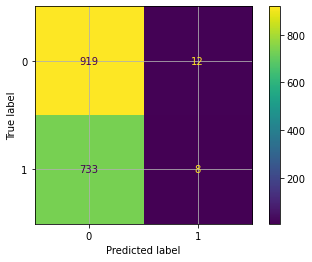

In [16]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
#https://stackoverflow.com/questions/63591238/fixing-confusion-matrix-plot-lines
metr = metrics.ConfusionMatrixDisplay(confusion_matrix = config, display_labels = bella_hadid.classes_)
metr.plot()
plt.grid(b=None)
None

* **Accuracy** показывает, какую долю признаков мы в целом угадываем. Рассчитывается как сумма всех угаданных параметров, деленная на количество ввсех имеющихся категорий. То есть это (TN + TP) / (TN + TP + FN + FP) = (919 + 8) / (919 + 8 + 733 + 12) = 0.5544
* **Точность** показывает, какова доля истинных угаданных 1 классов из всех названных 1 классов модели. Рассчитывается как отношение правильно угаданного 1 класса к сумме правильно угаданного 1 класса и неправильно угаданного первого класса. То есть TP / (TP + FP) = 8 / (8 + 12) = 0.4
* **Полнота** показывает, какую долю первых классов из всех имеющихся истинных предсказала модель. Рассчитвается как отношение правильно угаданного 1 класса к сумме правильно угаданного 1 класса и неправильно угаданного 0 класса. То есть TP / (TP + FN) = 8 / (8 + 733) = 0.0108

In [17]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}', '\n', '\n',
      f'Accuracy score с нулями: {accuracy_score(np.zeros_like(y_test), y_pred)}', '\n', '\n',
      f'Precision score: {precision_score(y_test, y_pred)}', '\n', '\n',
     f'Recall score: {recall_score(y_test, y_pred)}', '\n', '\n')

Accuracy score: 0.5544258373205742 
 
 Accuracy score с нулями: 0.9880382775119617 
 
 Precision score: 0.4 
 
 Recall score: 0.010796221322537112 
 



In [18]:
y_test.value_counts()

0    931
1    741
Name: gender, dtype: int64

**Вывод:** 
* Проблема крайне низкого показателя полноты заключается в выборе порога: судя по всему, большая часть истинных 1 в модели получили вероятности меньше 0.5. Однако те, которые оказались больше 0.5, в 40% случаев действительно оказались истинными и были классифицированы моделью правильно. В этом заключается проблема метрик recall и precision - при рассмотрении только одного порога трудно оценить качество модели, поэтому необходимо применить более обобщенные методы для получиения оптимального порога.
* Accuracy score демонтрирует основную проблему, связанную с данными в целом: на имеющийся небольшой дизбаланс классов накладывается плохо построенная модель. В случае, если изначальные истинне значения тестовой выборки изменить на нули, но предсказанные значения вместе с ними будут давать accuracy score 98,8%. То есть модель практически не предсказывает 1 класс, и, соответственно, поэтому в текущем датасете accuracy - крайне нерепрезентативный показатель. Задача состоит в оптимальном подборе точности и полноты, чтобы меньшинство 1 класса также было адекватно предсказано. А выполнить это можно засчет изменения порога отсечения меток классов или засчет настройки изначальных данных или даже засчет введения регуляризации самой модели.
* **Из 741 значений первого класса модель определила верно только 8.... (recall)**

![meme1.png](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTr63Iqda6CsJYz_8XPyERo6zif-_1tFcZvPw&usqp=CAU)

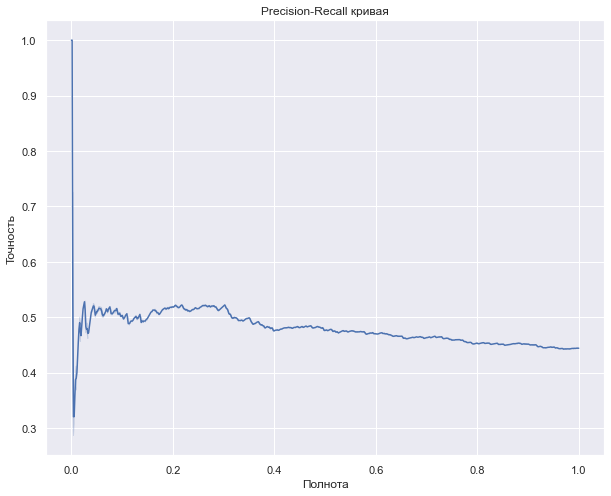

In [19]:
# Для начала построим precision-recall кривую, так как она проще интерпретируется в терминах полноты и точности:
pres, rec, ct = precision_recall_curve(y_test, first_pred)
sns.set(rc={'figure.figsize':(10,8)})
grabgh = sns.lineplot(rec, pres)
grabgh.set(xlabel = 'Полнота', ylabel = 'Точность', title = 'Precision-Recall кривая')
None

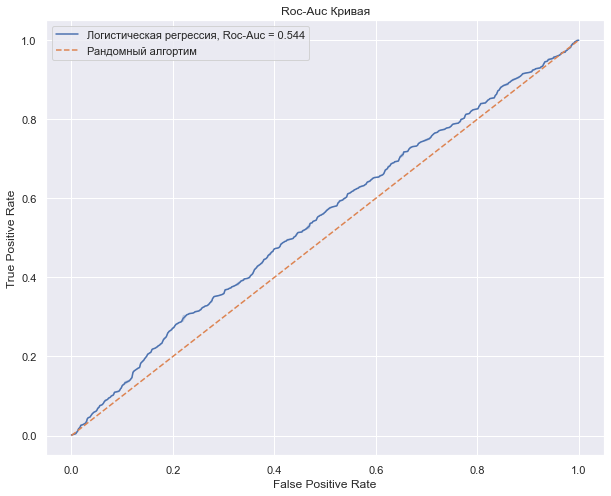

In [20]:
# Построим roc-auc кривую:
sns.set(rc={'figure.figsize':(10,8)})
fallspos, trupos, _ = roc_curve(y_test, first_pred)
score = round(roc_auc_score(y_test, first_pred),4)
grabgh1 = sns.lineplot(fallspos, trupos, label = f'Логистическая регрессия, Roc-Auc = {score}')
grabgh1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Roc-Auc Кривая')
sns.lineplot([0, 1], [0, 1], label = "Рандомный алгортим", linestyle='--')
None

### Вывод

Как вы оцениваете качество получившейся модели и возможные причины такого качества?

__Ваш вывод__:
* Качество обученной модели крайне неудовлетворительно, так как результаты практически не отличаются от рандомного алгоритма классификации
* Настройка порога точно не поможет, так как вне зависимости от его изменения, как следует из roc-auc кривой, результаты не улучшатся
* Precision-Recall кривая также имеет крайне странную форму, так как с ростом полноты точноть практически не снижается. Более того, при низких значениях полноты (околонулевых) точность значительно падает. С этим точно нужно что-то делать и спасать данные от такой кривой оценки

![meme.png](https://www.mihaileric.com/static/logistic_regression_meme-dc70fd90996941296fb922886a138053-ed51e.jpg)

---------------------------------

# Часть 2: мб сделаем что-то более серьёзное? [макс 20 баллов]

Давайте попробуем улучшить качество решения задачи за счёт другого метода подготовки данных.

Ранее мы использовали простое преобразование, когда каждый клиент описывался только 3 значениями.
Давайте сделаем что-то более сложное и попробуем добавить больше данных о клиенте для модели.

## Подготовка данных [15 баллов]

Воспользуемся тем, что каждая транзакция у нас имеет свой тип - это уж точно более информативно, чем агрегация по всем транзакциям.

Создайте сводную таблицу, где для каждого клиента (строка) будут указаны его суммарные траты на каждую категорию (столбец). Таким образом, вы должны получить таблицу с числом строк равным количеству клиентов и числом столбцов - количеству категорий трат. Каждая ячейка должна содержать суммарные траты данного клиента в данной категории.

__Подсказка__: у DataFrame есть полезный метод `pivot_table`.

In [21]:
new_dada = pd.pivot_table(trans,
                values = ['value'],
               index=['user_id'],
               columns=['type'],
               aggfunc=np.sum, fill_value=0)
new_dada.columns = new_dada.columns.droplevel([0])
new_dada.shape, trans['type'].nunique()

((8356, 184), 184)

In [22]:
new_dada = new_dada.merge(gen, how='left', on='user_id')
new_dada["gender"] = new_dada["gender"].astype(int)

In [23]:
new_dada.head()

,user_id,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,...,"Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,gender
0,22899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,27914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,28753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,31385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,38084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


---------------------------

## Обучение и валидация модели [5 баллов]

Аналогично предыдущей части разделите данные на обучающую и тестовую выборку (80%/20%), обучите модель на дефолтных параметрах и оцените качество.

In [24]:
new_dada = new_dada.set_index('user_id')
dada_y = new_dada["gender"]
dada_x = new_dada.drop(columns=["gender"])
X_train, X_test, y_train, y_test = train_test_split(dada_x, dada_y, test_size=0.2, random_state=1337)

In [25]:
emily_ratajkowski  = LogisticRegression()
emily_ratajkowski.fit(X_train, y_train)
y_pred = emily_ratajkowski.predict_proba(X_test)

In [26]:
first_pred = y_pred[:,1] # предсказания вероятностей первого коласса

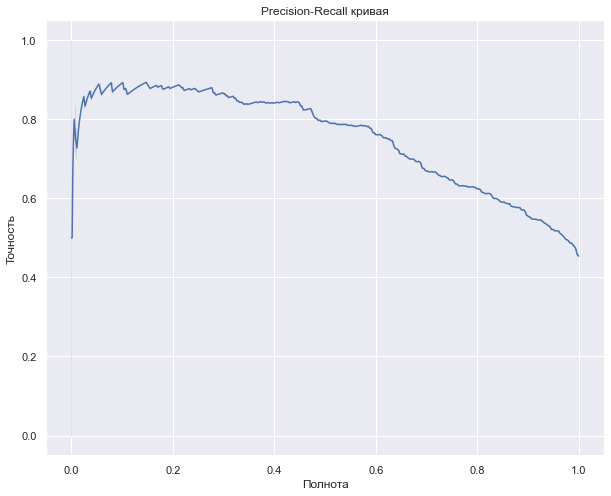

In [27]:
pres, rec, ct = precision_recall_curve(y_test, first_pred)
sns.set(rc={'figure.figsize':(10,8)})
grabgh = sns.lineplot(rec, pres)
grabgh.set(xlabel = 'Полнота', ylabel = 'Точность', title = 'Precision-Recall кривая')
None

In [28]:
# Найдем оптимальный показатель отсечения: точка, которая наиболее близко расположена к Recall = 1 и Precision = 1
# Сделано это потому, что в данных не указано, какой именно показатель важнее, поэтому можно максимизировать оба и сразу
unos = np.ones_like(pres)
gipotenuza = sqrt((unos - pres) ** 2 + (unos - rec) ** 2)
nomer = np.where(gipotenuza == gipotenuza.min())
print(rec[nomer]) # оптимальное значение Recall
print(pres[nomer]) # оптимальное значение Precision

[0.80701754]
[0.62291667]


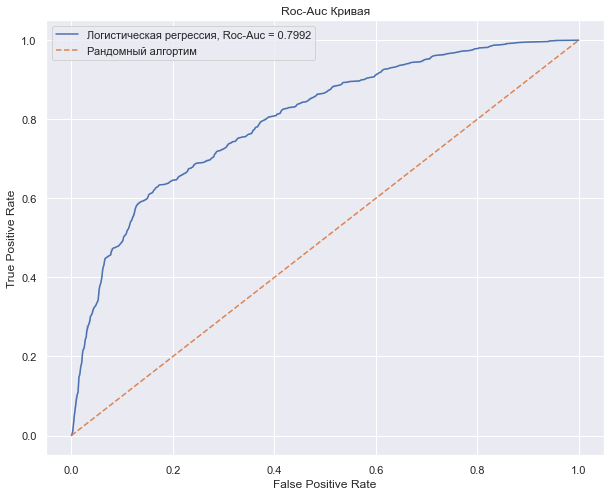

In [29]:
# Построим roc-auc кривую:
sns.set(rc={'figure.figsize':(10,8)})
fallspos, trupos, threshold = roc_curve(y_test, first_pred)
score = round(roc_auc_score(y_test, first_pred),4)
grabgh1 = sns.lineplot(fallspos, trupos, label = f'Логистическая регрессия, Roc-Auc = {score}')
grabgh1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Roc-Auc Кривая')
sns.lineplot([0, 1], [0, 1], label = "Рандомный алгортим", linestyle='--')
None

In [30]:
# Найдем оптимальный показатель отсечения: точка, которая наиболее близко расположена к TRP = 1
unos = np.ones_like(fallspos)
gipotenuza = sqrt((unos - trupos) ** 2 + fallspos ** 2)
nomer = np.where(gipotenuza == gipotenuza.min())
prohod = threshold[nomer] # получили порог, максимизирующий True Postitve Rate, то есть 

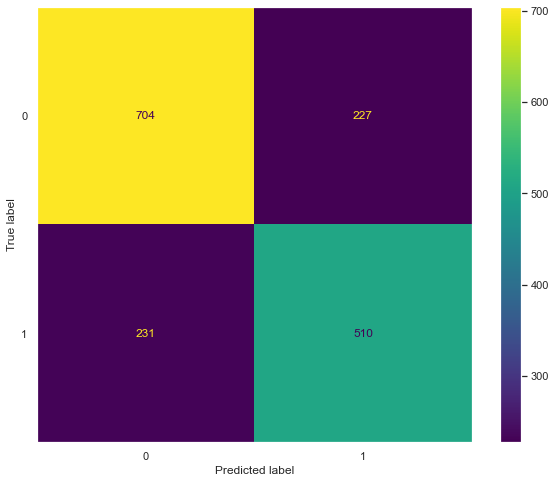

In [31]:
y_pred = 1*(first_pred >= prohod)
config = confusion_matrix(y_test, y_pred)
metr = metrics.ConfusionMatrixDisplay(confusion_matrix = config, display_labels = emily_ratajkowski.classes_)
metr.plot()
plt.grid(b=None)
None

In [32]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}', '\n', '\n',
      f'Accuracy score с нулями: {accuracy_score(np.zeros_like(y_test), y_pred)}', '\n', '\n',
      f'Precision score: {precision_score(y_test, y_pred)}', '\n', '\n',
     f'Recall score: {recall_score(y_test, y_pred)}', '\n', '\n')

Accuracy score: 0.7260765550239234 
 
 Accuracy score с нулями: 0.5592105263157895 
 
 Precision score: 0.6919945725915875 
 
 Recall score: 0.6882591093117408 
 



### Вывод 

Изменилось ли качество модели? Почему?

__Ваш вывод:__
* Модель значительно улучшила свои результаты: это особенно заметно по площади под кривой ROC-AUC - она возросла с 0.54 до 0.8
* Если подбирать оптимальный порог по оптимизации Roc-Auc кривой, то итоговые значения точности и полноты значительно улучшились: 0,74 и 0,63 соответственно
* Такие резульататы были получены благодаря созданию новых признаков для модели. В первый раз признака было всего три: сумма покупки, ее средняя и выборочная несмещенная дисперсия. Все эти численные показатели были относительно похожи между собой, поэтому не давали четкого разделения между двумя таргетами 0 и 1. Когда же мы создали для каждого покупателя сразу по 184 признака, демонстрирующих сколько и на какую категорию продукции тратил каждый индивид, мы получили более выраженную классификацию. В целом для повышения качества моделей в регрессиях часто используют создание новых признаков (в случае численных,их например возводят в степени или перемножают между собой), но в этом деле обязательно необходимо соблюдать баланс: можно насоздавать столько признаков, что модель переобучится и на тестовой выборке будет показывать крайне плачевные резульаты при практически минимальных ошибках в тренировочной

### Также для более интуитивно понятного сравнения проведем анализ, используя крайне неоптимальный порог 0.5 и сравиним результаты с предыдущим пунктом:

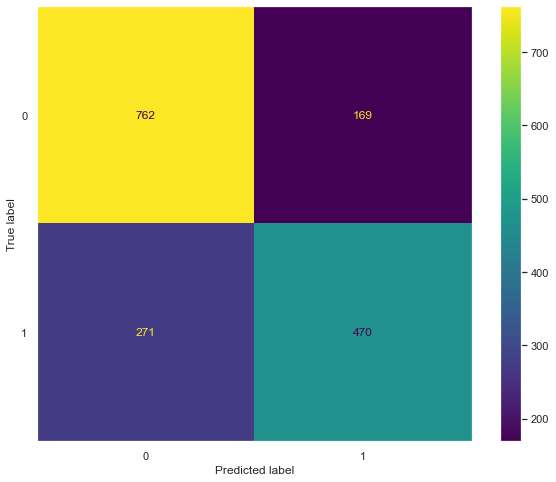

In [33]:
y_pred = 1*(first_pred >= 0.5)
config = confusion_matrix(y_test, y_pred)
metr = metrics.ConfusionMatrixDisplay(confusion_matrix = config, display_labels = emily_ratajkowski.classes_)
metr.plot()
plt.grid(b=None)
None

In [34]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}', '\n', '\n',
      f'Accuracy score с нулями: {accuracy_score(np.zeros_like(y_test), y_pred)}', '\n', '\n',
      f'Precision score: {precision_score(y_test, y_pred)}', '\n', '\n',
     f'Recall score: {recall_score(y_test, y_pred)}', '\n', '\n')

Accuracy score: 0.7368421052631579 
 
 Accuracy score с нулями: 0.617822966507177 
 
 Precision score: 0.7355242566510172 
 
 Recall score: 0.6342780026990553 
 



**Вывод:** 

* Precision улучшился более чем на 0.4. Значительный результат также заметен и в recall score - он увеличился почти с нулевого значения до 0.55 в данном пункте. Это улучшение в целом также демонстрирует значительное увеличение ROC-AUC score - теперь он заметно лучше рандомного

-------------------------


# Часть 3: что мы всё про данные? Давайте про модель 
# [макс 30 баллов]

Ранее мы работали только над подготовкой обучающей выборки. Давайте теперь попробуем изменить модель, чтобы добиться наилучшего качества. 

Входные данные для этой части - выборка с предыдущей.

## Нормирование данных [5 баллов] 

Как мы знаем, линейные модели любят нормированные данные.

Приведите значения всех признаков в отрезок [0, 1]

__Замечание__: если вы используете метод, который удаляет информацию о названиях колонок - сохраните эти названия в отдельную переменную, вам это потом может понадобиться.

In [35]:
dada_y = new_dada["gender"]
dada_x = new_dada.drop(columns=["gender"])
feature_names = dada_x.columns.values

In [36]:
# https://scikit-learn.org/stable/modules/preprocessing.html
min_max_scaler = preprocessing.MinMaxScaler()
dada_x_norm = min_max_scaler.fit_transform(dada_x)

In [37]:
dada_x_norm = pd.DataFrame(dada_x_norm, columns = feature_names)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(dada_x_norm, dada_y, test_size=0.2, random_state=1337)

In [39]:
dada_x

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,"Фотостудии, фотолаборатории","Химикалии и смежные вещества, не классифицированные ранее",Химчистки,Ценные бумаги: брокеры/дилеры,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование
user_id,,,,,,,,,,,,,,,,,,,,,
22899,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
27914,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
28753,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
31385,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
38084,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953525,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
99967537,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
99988578,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4267.24,0.0,0.0,0.0,0.0


## Подбор параметров [15 баллов]

Подберите наилучшие параметры для модели логистической регрессии. Важные уточнения:

* используйте перебор по сетке
* в качестве метрики используйте ROC AUC
* для оценки параметров делайте кросс-валидацию на 4 фолдах

__Замечание__: у логистической регрессии множество доступных значений для некоторых параметров зависит от метода оптимизации (solver). Например, lbfgs-алгоритм не подерживает l1-регуляризацию.

Поэтому действуйте шагами: сначала подберите solver, а потом уже переберите доступные для него параметры.

In [40]:
kylie_jenner = Pipeline(steps=[
    ('regression', LogisticRegression(solver = 'liblinear'))
])

kylie_jenner.fit(X_train, y_train)

y_repr = kylie_jenner.predict_proba(X_test)

score = kylie_jenner.score(X_train, y_train)

print(score)

0.6976361460203471


In [41]:
# Код из семинара 9

kylie_jenner = Pipeline(steps=[
    ('regression', LogisticRegression(solver = 'liblinear'))
])

alphas = np.logspace(-2, 4, 20)

searcher_kylie_jenner = GridSearchCV(kylie_jenner, [{"regression__C": alphas}],
                        scoring="roc_auc", cv=4, n_jobs=-1)
searcher_kylie_jenner.fit(X_train, y_train)

best_alpha = searcher_kylie_jenner.best_params_["regression__C"]
best_score = searcher_kylie_jenner.best_score_

Best alpha = 29.7635
Best score = 0.7900


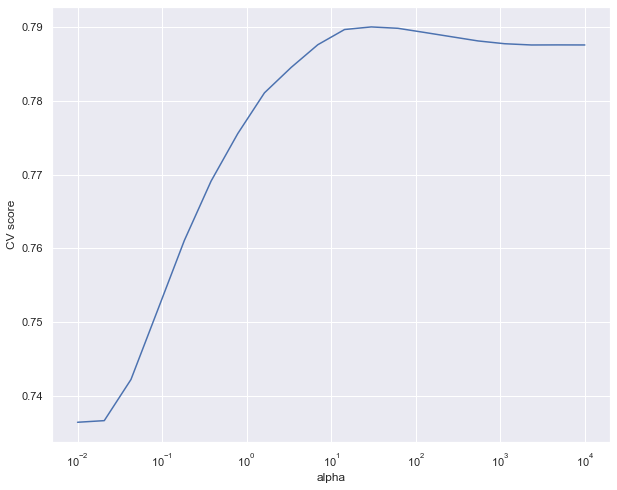

In [42]:
print("Best alpha = %.4f" % best_alpha)
print("Best score = %.4f" % best_score)

plt.plot(alphas, searcher_kylie_jenner.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

#### Теперь попробуем перебрать всевозможные солверы и ограничители. Возможно, получится улучшить оценку

In [43]:
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
kylie_jenner = LogisticRegression()

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = np.logspace(-2, 4, 20)

searcher_kylie_jenner = GridSearchCV(kylie_jenner, space,
                        scoring="roc_auc", cv=4, n_jobs=-1)
resutlt = searcher_kylie_jenner.fit(X_train, y_train)

In [44]:
print('Best Score: %s' % resutlt.best_score_)
print('Best Hyperparameters: %s' % resutlt.best_params_)
# Таким образом, будем использовать солвер liblinear и пенальти категории l1

Best Score: 0.7970070471979518
Best Hyperparameters: {'C': 3.359818286283781, 'penalty': 'l1', 'solver': 'liblinear'}


Оцените качество лучшей модели на тестовых данных аналогично предыдущим задачам.

In [45]:
kendall_jenner = LogisticRegression(C = 3.359818286283781, penalty = 'l1', solver = 'liblinear')
kendall_jenner.fit(X_train, y_train)
y_pred = kendall_jenner.predict_proba(X_test)
first_pred = y_pred[:,1]

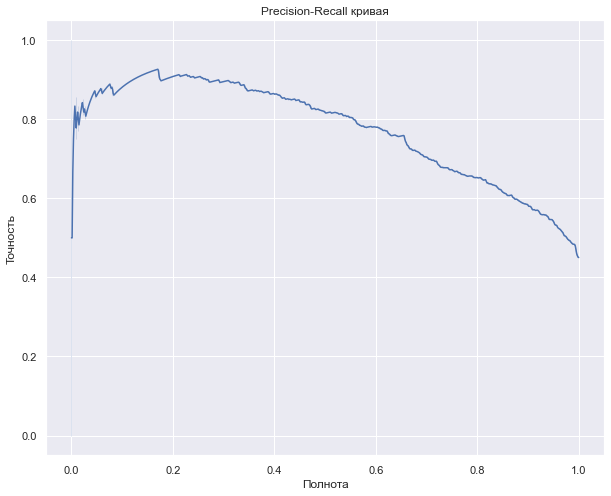

In [46]:
#Построим Precision-Recall кривую
pres, rec, ct = precision_recall_curve(y_test, first_pred)
sns.set(rc={'figure.figsize':(10,8)})
grabgh = sns.lineplot(rec, pres)
grabgh.set(xlabel = 'Полнота', ylabel = 'Точность', title = 'Precision-Recall кривая')
None

In [47]:
# Найдем оптимальный показатель отсечения: точка, которая наиболее близко расположена к Recall = 1 и Precision = 1
# Сделано это потому, что в данных не указано, какой именно показатель важнее, поэтому можно максимизировать оба и сразу
unos = np.ones_like(pres)
gipotenuza = sqrt((unos - pres) ** 2 + (unos - rec) ** 2)
nomer = np.where(gipotenuza == gipotenuza.min())
print(rec[nomer]) # оптимальное значение Recall
print(pres[nomer]) # оптимальное значение Precision

[0.81781377]
[0.6474359]


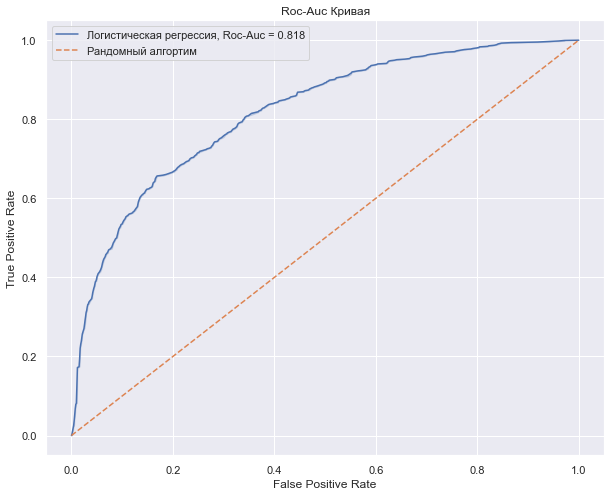

In [48]:
# Построим roc-auc кривую:
sns.set(rc={'figure.figsize':(10,8)})
fallspos, trupos, threshold = roc_curve(y_test, first_pred)
score = round(roc_auc_score(y_test, first_pred),4)
grabgh1 = sns.lineplot(fallspos, trupos, label = f'Логистическая регрессия, Roc-Auc = {score}')
grabgh1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Roc-Auc Кривая')
sns.lineplot([0, 1], [0, 1], label = "Рандомный алгортим", linestyle='--')
None

In [49]:
# Найдем оптимальный показатель отсечения: точка, которая наиболее близко расположена к TRP = 1
unos = np.ones_like(fallspos)
gipotenuza = sqrt((unos - trupos) ** 2 + fallspos ** 2)
nomer = np.where(gipotenuza == gipotenuza.min())
prohod = threshold[nomer] # получили порог, максимизирующий True Postitve Rate, то есть 

In [50]:
prohod

array([0.43892646])

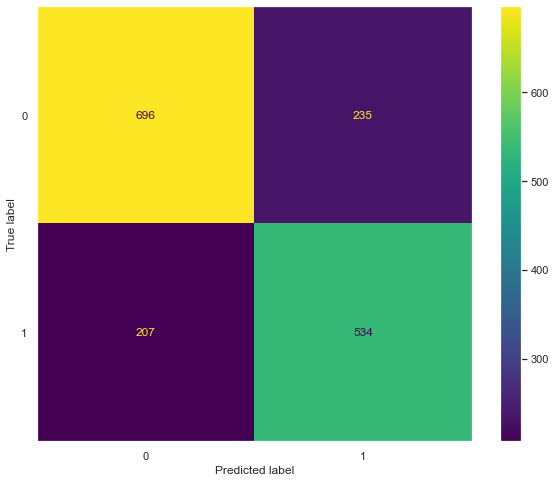

In [51]:
y_pred = 1*(first_pred >= prohod)
config = confusion_matrix(y_test, y_pred)
metr = metrics.ConfusionMatrixDisplay(confusion_matrix = config, display_labels = kendall_jenner.classes_)
metr.plot()
plt.grid(b=None)
None

In [52]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}', '\n', '\n',
      f'Accuracy score с нулями: {accuracy_score(np.zeros_like(y_test), y_pred)}', '\n', '\n',
      f'Precision score: {precision_score(y_test, y_pred)}', '\n', '\n',
     f'Recall score: {recall_score(y_test, y_pred)}', '\n', '\n')

Accuracy score: 0.7356459330143541 
 
 Accuracy score с нулями: 0.5400717703349283 
 
 Precision score: 0.694408322496749 
 
 Recall score: 0.7206477732793523 
 



### Также для более интуитивно понятного сравнения проведем анализ, используя крайне неоптимальный порог 0.5 и сравиним результаты с предыдущим пунктом:

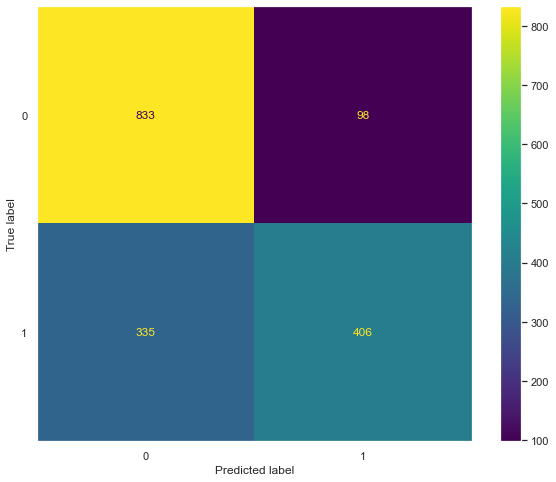

In [53]:
y_pred = 1*(first_pred >= 0.5)
config = confusion_matrix(y_test, y_pred)
metr = metrics.ConfusionMatrixDisplay(confusion_matrix = config, display_labels = kendall_jenner.classes_)
metr.plot()
plt.grid(b=None)
None

In [54]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}', '\n', '\n',
      f'Accuracy score с нулями: {accuracy_score(np.zeros_like(y_test), y_pred)}', '\n', '\n',
      f'Precision score: {precision_score(y_test, y_pred)}', '\n', '\n',
     f'Recall score: {recall_score(y_test, y_pred)}', '\n', '\n')

Accuracy score: 0.7410287081339713 
 
 Accuracy score с нулями: 0.6985645933014354 
 
 Precision score: 0.8055555555555556 
 
 Recall score: 0.5479082321187584 
 



Получилось ли добиться лучше качества при подборе параметров?
Почему так? 

Для чего мы использовали одновременно кросс-валидацию и отложенную тестовую выборку?

__Ваш вывод__:

* Было: Accuracy = 0.74, Precision = 0.74, Recall = 0.63, ROC-AUC = 0.8
* Стало: Accuracy = 0.74, Precision = 0.81, Recall = 0.55, ROC-AUC = 0.82
* **Таким образом, значительного улучшения подбор параметров не принес. Однако если сравнивать прошлый пункт с позоброшлым - то есть там, где происходило изменение формата данных - относительно того серьезного изменения проведенный гридсерч никакой пользы не привнес

Кросс-валидация используется для того, чтобы нивелировать эффект неравномерности распределения признаков в выборке, то есть даже если в случае одной неудачной случайности разделения данный на тренировочную и тестовую было еще 3 других фолда, которые в общей картине могли скомпенсировать и усреднить итоговые оптимальные параметры модели (чтобы она и не переучилась, и чтобы достаточно равномерно отражала показатели обучающей выборки для лучших тестовых результатов.

Таким образом, на обучающей выборке после 4 перестановок формируется оптимальная усредненная модель с показателями, которая предположительно должна лучше всего себя показать на тестовой и предотвратить "неслучайной" train-test splita

## Подбор отсечения [5 баллов]

Ранее мы работали или с вероятностями из модели или с метками, полученных при отсечении по веростности с порогом 0.5.

Стоит сказать, что порог 0.5 для разделения классов не всегда самый лучший. Часто нам нужно так подобрать порог, чтобы удовлетворить наши требования по точности и полноте.

Давайте подберём порог, который максимизирует F_beta меру при условии, что нам полнота в 5 раз важнее точности.

Вычислите наилучший порог и нарисуйте график зависимости этой метрики от порога разделения.

In [55]:
x2 = np.linspace(0,1, 10**5)
sumting = np.array([])

In [56]:
# В предыдущих пунктов для поиска оптимального порога отсечения использовалась roc-auc кривая. В этом пункте будем использовать
# другую метрику - f_beta score
from tqdm import tqdm
for i in tqdm(x2):
    y_pred = 1*(first_pred >= i)
    f = fbeta_score(y_test, y_pred, beta=sqrt(5))
    sumting = np.append(sumting, f)
# ну gridsearch тоже долго выполнялся

100%|██████████| 100000/100000 [01:31<00:00, 1088.43it/s]


In [57]:
bochka = dict()
bochka['Максимальный порог'] = [x2[sumting.argmax()]]
bochka['Максимальное значение f-beta score'] = [sumting.max()]
bochka = pd.DataFrame(bochka)

Оптимальный порог отсечения в модели равен 0.23288232882328824
Оптимальная оценка f-beta 0.8448207955888145


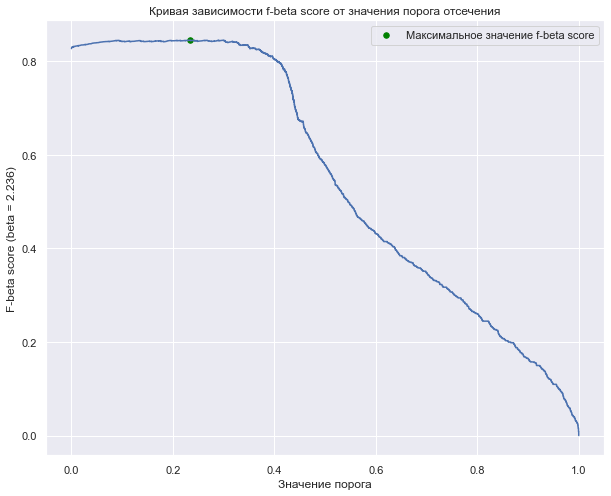

In [58]:
print('Оптимальный порог отсечения в модели равен %s' % x2[sumting.argmax()])
print('Оптимальная оценка f-beta %s' % sumting.max())
kachan = sns.lineplot(x = x2, y = sumting)
kachan.set(xlabel = 'Значение порога', ylabel = 'F-beta score (beta = 2.236)', title = 'Кривая зависимости f-beta score от значения порога отсечения')
kachan.scatter(data = bochka, x = 'Максимальный порог', y = 'Максимальное значение f-beta score', s = 30, color = 'green')
kachan.legend()
None

## Интерпретация модели [5 баллов]

Часто нам хочется интерпритировать предсказания модели - понять, как наши признаки влияют на её ответ.
В случае сложных моделей сделать это не просто - чем сложнее модель, тем более сложные закономерности она извлекает и тем тяжелее нам их понять.

Но в случае логистической регресии это просто сделать, посмотрев на её обучаемые параметры (вспоминайте!).

Получите список признаков, которые увеличивают вероятность метки 0.
Аналогично для метки 1.

In [59]:
# kendall_jenner.coef_, kendall_jenner.intercept_
boba = pd.DataFrame(np.hstack((feature_names.reshape(184,1), kendall_jenner.coef_.reshape(184,1))))

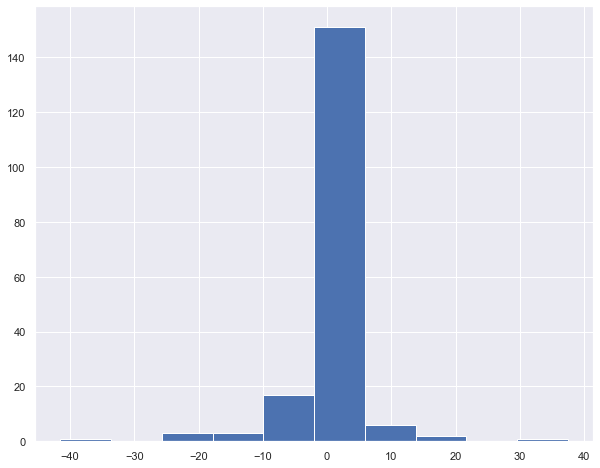

In [60]:
plt.hist(kendall_jenner.coef_.tolist())
None
# Положительные коэффициенты предсказывают метку 1, в то время как отрицательные - метку 0

In [61]:
# Признаки, которые увеличивают вероятности метки 1
first_priznak = boba[boba[1] > 0][0].values
print(*first_priznak, sep = "; ")

Авиалинии, авиакомпании; Автозапчасти и аксессуары; Автоматизированные бензозаправки; Автомойки; Автошины; Агентства по аренде автомобилей; Бакалейные магазины, супермаркеты; Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков; Беспошлинные магазины Duty Free; Билльярд-клубы; Булочные; Бытовое оборудование; Веломагазины — продажа и обслуживание; Видеопрокат; Галереи и художественные посредники; Галереи/учреждения видеоигр; Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу; Горючее топливо — уголь, нефть, разжиженный бензин, дрова; Денежные переводы MasterCard MoneySend; Жилье — отели, мотели, курорты; Иной сервис; Информационные провайдеры; Кабельные и другие платные телевизионные услуги; Канцелярия, офисные сопутствующие товары, бумага для печатания и письма; Кинотеатры; Клубы — сельские клубы, членство(спортивный, отдых, спорт), частные поля для гольфа; Книжные магазины; Компьютерная сеть/информационные услуги; Компьютеры, пер

In [62]:
# Признаки, которые увеличивают вероятности метки 0
zero_priznak = boba[boba[1] < 0][0].values
print(*zero_priznak, sep = "; ")

Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка; Аксессуары для женщин; Аптеки; Ветеринарные услуги; Готовая женская одежда; Дантисты, ортодонтисты; Денежные переводы; Звонки с использованием телефонов, считывающих магнитную ленту; Зоомагазины; Зубные и медицинские лаборатории; Изготовление и продажа меховых изделий; Коммунальные услуги — электричество, газ, санитария, вода; Лекарства, их распространители, аптеки; Магазины second hand, магазины б/у товаров, комиссионки; Магазины косметики; Магазины мужской и женской одежды; Магазины открыток, подарков, новинок и сувениров; Магазины офисных, школьных принадлежностей, канцтоваров; Магазины по продаже часов, ювелирных изделий и изделий из серебра; Магазины ткани, ниток рукоделия, шитья; Магазины хрусталя и изделий из стекла; Магазины художественных и ремесленных изделий; Магазины, торгующие по сниженным ценам; Нефть и нефтепродукты; Образовательные услуги; Одеж

# Часть 4: ва-банк / пространство для творчества [макс 30 баллов]

Добейтесь максимального качества, больше качество - больше баллов.

Стратегия подготовки данных и обучения модели на ваше усмотрение.

Условия:
* Оценка на отложенной тестовой группе пользователей, использовавшейся в прошлых пунктах (20%)
* В качестве метрики используйте ROC_AUC

__Замечание__: 

Ответа на вопрос "какое нужно качество для максимального балла?" не будет.

Используйте все свои знания, чтобы добиться наилучшего результата.

In [63]:
trans = pd.read_csv("transactions.csv", sep = ";")
gen = pd.read_csv("gender.csv")
trans = trans.merge(gen, how='left', on='user_id')
trans.head()

,user_id,dt,type,value,gender
0,39026145,0 10:23:26,"Звонки с использованием телефонов, считывающих...",2695.099,1.0
1,39026145,6 07:08:31,"Звонки с использованием телефонов, считывающих...",2358.212,1.0
2,39026145,8 07:06:10,"Звонки с использованием телефонов, считывающих...",2807.395,1.0
3,39026145,11 08:49:03,"Звонки с использованием телефонов, считывающих...",2695.099,1.0
4,39026145,11 14:12:08,"Звонки с использованием телефонов, считывающих...",2695.099,1.0


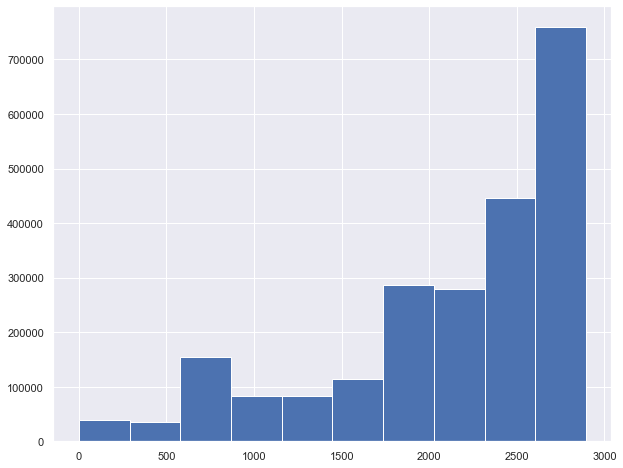

In [64]:
plt.hist(trans['value'])
None

In [65]:
epic_minecraft = pd.pivot_table(trans,
                values = ['value'],
               index=['user_id'],
               columns=['type'],
               aggfunc=np.sum, fill_value=0)
epic_minecraft.columns = epic_minecraft.columns.droplevel([0])
epic_minecraft = epic_minecraft.merge(gen, how='left', on='user_id')

In [66]:
epic_minecraft = epic_minecraft.set_index('user_id')
epic_y = epic_minecraft["gender"]
epic_x = epic_minecraft.drop(columns=["gender"])
feature_names = epic_x.columns.values

In [100]:
#отминимаксим категории покупок
min_max_scaler = preprocessing.MinMaxScaler()
epic_x_norm = min_max_scaler.fit_transform(epic_x)
epic_x_norm = pd.DataFrame(epic_x_norm, columns = feature_names)

In [68]:
#количество покупок, также отминимаксим - создание нового признака
mokko = trans['user_id'].value_counts().to_frame().reset_index()
mokko.rename(columns = {'index' : 'user_id', 'user_id' : 'transactions'}, inplace = True)
mokko = mokko.sort_values(by = 'user_id', ascending=True)
mokko = mokko.set_index('user_id')
mokko_norm = min_max_scaler.fit_transform(mokko)
mokko_norm = pd.DataFrame(mokko_norm, columns = ['transactions'])

In [69]:
# Создадим признак: в какое время суток - утреннее время, дневное, вечернее или ночное - совершались покупки одним индивидом
kabachok = pd.DataFrame()
kabachok[["day", "time"]] = trans["dt"].str.split(' ',expand=True)
kabachok["time"] = pd.to_datetime(kabachok["time"], format='%H:%M:%S')

In [70]:
kabachok["utro"] = np.where((kabachok["time"].dt.hour >= 6) & (kabachok["time"].dt.hour <= 12), 1,0)
kabachok["day"] = np.where((kabachok["time"].dt.hour > 12) & (kabachok["time"].dt.hour <= 16),1,0)
kabachok["evening"] = np.where((kabachok["time"].dt.hour > 16) & (kabachok["time"].dt.hour <= 22),1,0)
kabachok["night"] = np.where((kabachok["time"].dt.hour > 22) | (kabachok["time"].dt.hour < 6),1,0)

In [71]:
kabachok = kabachok.drop(["time"], axis = 1)

In [72]:
mister = trans['user_id'].to_frame().join(kabachok)
mister = mister.groupby("user_id")["day","utro","evening","night"].sum() 
# создали датафремй с данными о количестве транзакций, совершенных человеком в каждое время суток

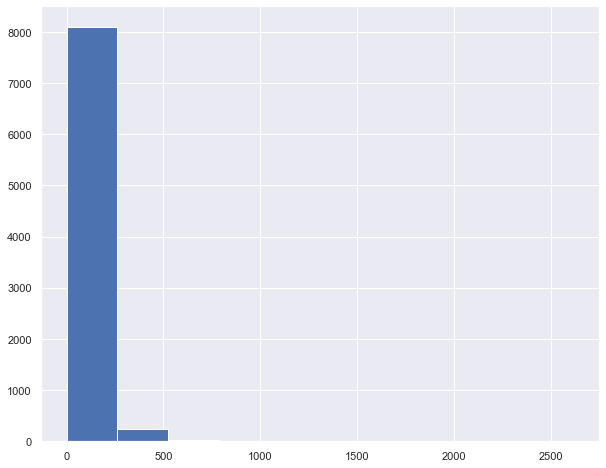

In [73]:
plt.hist(mister["night"])
None

In [74]:
mister_norm = min_max_scaler.fit_transform(mister)
mister_norm = pd.DataFrame(mister_norm, columns = ['utro', 'day', 'evening','night'])

In [101]:
epic_x_norm = epic_x_norm.join(mister_norm)

In [91]:
#epic_x_norm = epic_x_norm.join(mokko_norm)

In [102]:
epic_x_norm.head()

,"Авиалинии, авиакомпании","Авиалинии, авиакомпании, нигде более не классифицированные",Автобусные линии,Автозапчасти и аксессуары,Автоматизированные бензозаправки,Автомойки,Автошины,"Агентства по автотранспортным перевозкам, местные/дальные автогрузоперевозки, компании попереезду и хранению, местная доставка",Агентства по аренде автомобилей,Агенты и менеджеры по аренде недвижимости,...,Центры здоровья,"Цифровые товары, игры",Школы — бизнес и секретарей,Штрафы,"Штучные товары, галантерея и другие текстильные товары",Электрические части и оборудование,utro,day,evening,night
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009465,0.012414,0.019658,0.007634
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006507,0.008828,0.005707,0.001145
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004141,0.015172,0.001268,0.021374
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.021591,0.028414,0.081167,0.001908
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.052943,0.052690,0.107800,0.041603


In [103]:
X_train, X_test, y_train, y_test = train_test_split(epic_x_norm, epic_y, test_size=0.2, random_state=1337)

In [96]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

#1)Первый параметр леса - количество деревьев 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

#2)Второй параметр - критерий, по которому считается качество разделения
criterion = ['gini', 'entropy', 'log_loss']

#3)Максимальная глубина дерева
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

#4)Минимальное количество выборок, необходимое для разделения внутреннего узла:
min_samples_split = [2, 5, 10]

#5)Минимальное количество выборок, необходимое для размещения в конечном узле. 
#Точка разделения на любой глубине будет учитываться только в том случае, 
#если она оставляет по крайней мере обучающие выборки min_samples_leaf в каждой из левой и правой ветвей
min_samples_leaf = [1, 2, 4]

#6)min_weight_fraction_leaf - не принципиально, можно оставить базовым нулем


#7)Количество функций, которые следует учитывать при поиске наилучшего разделения:
max_features = ['sqrt', 'log2']


# Method of selecting samples for training each tree
bootstrap = [True, False]

#Остальные параметря я не понял, что означают

# Создадим словарь параметров
params = {'n_estimators': n_estimators,
            'criterion' : criterion,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

hailey_baldwin = RandomForestClassifier()
# ДЛя надежности будем использовать 100 итераций, проверять на 4 фолдах
hailey_baldwin_random = RandomizedSearchCV(estimator = hailey_baldwin, param_distributions = params, 
                                           n_iter = 100, scoring = 'roc_auc', cv = 4, verbose=5, random_state=1337, 
                                           n_jobs = -1)
# hailey_baldwin_random = HalvingGridSearchCV(hailey_baldwin, params, scoring="roc_auc", cv=4, verbose = 3, n_jobs=-1)
# Fit the random search model
hailey_baldwin_random.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_s

In [97]:
hailey_baldwin_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 30,
 'criterion': 'entropy',
 'bootstrap': True}

-------------------------

In [80]:
# Это первая версия модели
hailey_baldwin = RandomForestClassifier(n_estimators = 1200, 
                                        min_samples_split = 5, 
                                        min_samples_leaf = 2, 
                                        max_features = 'sqrt',
                                        max_depth = 20,
                                        bootstrap = True)
hailey_baldwin.fit(X_train, y_train)
y_pred = hailey_baldwin.predict_proba(X_test)
first_pred = y_pred[:,1]

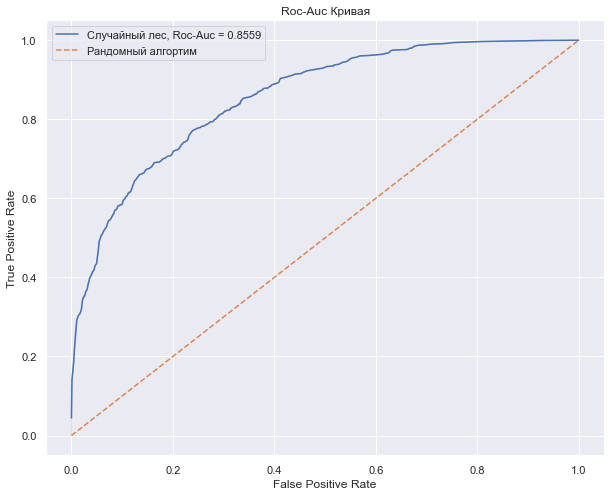

In [81]:
# Построим roc-auc кривую:
sns.set(rc={'figure.figsize':(10,8)})
fallspos, trupos, threshold = roc_curve(y_test, first_pred)
score = round(roc_auc_score(y_test, first_pred),4)
grabgh1 = sns.lineplot(fallspos, trupos, label = f'Случайный лес, Roc-Auc = {score}')
grabgh1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Roc-Auc Кривая')
sns.lineplot([0, 1], [0, 1], label = "Рандомный алгортим", linestyle='--')
None

---------------

In [104]:
# Это вторая версия модели после модернизации сёрча и добавления туда нескольких новых параметров
# Из-за этого итоговые оптимальные параметры для модели изменились (на несколько тысячных..........)
hailey_bieber = RandomForestClassifier(n_estimators = 1200, 
                                        min_samples_split = 2, 
                                        min_samples_leaf = 4, 
                                        max_features = 'log2',
                                        max_depth = None,
                                        criterion = "entropy",
                                        bootstrap = True)
hailey_bieber.fit(X_train, y_train)
y_pred = hailey_bieber.predict_proba(X_test)
first_pred = y_pred[:,1]

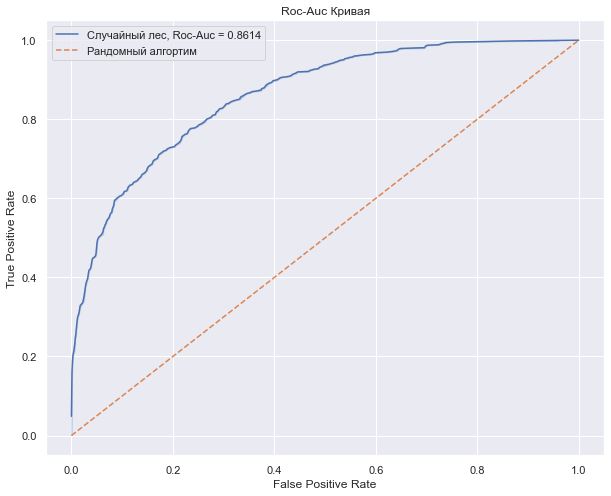

In [105]:
# Построим roc-auc кривую:
sns.set(rc={'figure.figsize':(10,8)})
fallspos, trupos, threshold = roc_curve(y_test, first_pred)
score = round(roc_auc_score(y_test, first_pred),4)
grabgh1 = sns.lineplot(fallspos, trupos, label = f'Случайный лес, Roc-Auc = {score}')
grabgh1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Roc-Auc Кривая')
sns.lineplot([0, 1], [0, 1], label = "Рандомный алгортим", linestyle='--')
None

In [84]:
# Найдем оптимальный показатель отсечения: точка, которая наиболее близко расположена к TRP = 1
unos = np.ones_like(fallspos)
gipotenuza = sqrt((unos - trupos) ** 2 + fallspos ** 2)
nomer = np.where(gipotenuza == gipotenuza.min())
prohod = threshold[nomer] # получили порог, максимизирующий True Postitve Rate, то есть
prohod

array([0.45564465])

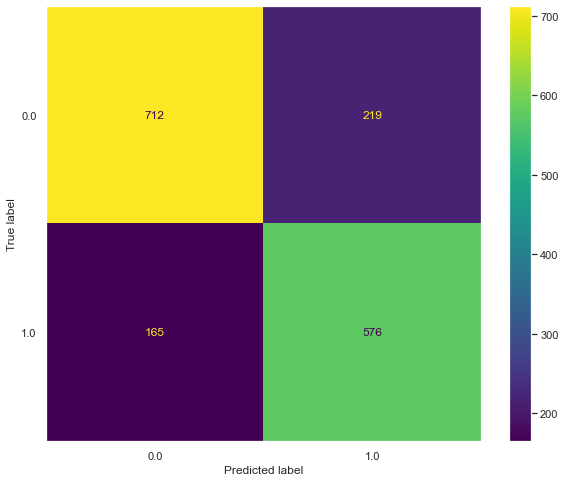

In [85]:
y_pred = 1*(first_pred >= prohod)
config = confusion_matrix(y_test, y_pred)
metr = metrics.ConfusionMatrixDisplay(confusion_matrix = config, display_labels = hailey_bieber.classes_)
metr.plot()
plt.grid(b=None)
None

In [86]:
y_pred = 1*(first_pred >= prohod)
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}', '\n', '\n',
      f'Precision score: {precision_score(y_test, y_pred)}', '\n', '\n',
     f'Recall score: {recall_score(y_test, y_pred)}', '\n', '\n')

Accuracy score: 0.7703349282296651 
 
 Precision score: 0.7245283018867924 
 
 Recall score: 0.7773279352226721 
 



**Вывод:** Добавление новых признаков, применение новой модели классификации и подбора для нее оптимальных парметров помогло увеличить ROC-AUC score c 0.818 до 0.861

------------------

### Я надеялся на случайный лес, но он по итогу не сильно улучшил результат
Попробую применить SVC

In [87]:
#https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2
#https://habr.com/ru/articles/430280/
#https://towardsdatascience.com/20x-times-faster-grid-search-cross-validation-19ef01409b7c
#https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501

In [88]:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
naomi_campbell = SVC()


param_grid = {'C':np.logspace(-2, 4, 20).tolist(),
              'gamma':[1,0.1,0.001,0.0001, "auto", "scale"], 
              'kernel': ["linear", "poly", "rbf", "sigmoid"]}

searcher_naomi_campbell = RandomizedSearchCV(naomi_campbell, param_grid,
                                        n_iter = 100,
                                        scoring="roc_auc", cv=4, n_jobs=-1)
searcher_naomi_campbell.fit(X_train, y_train)
searcher_naomi_campbell.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'C': 127.42749857031322}

In [89]:
# Протестируем эту модель, а далее скомбинируем с другими
naomi_campbell = SVC(kernel = 'rbf', gamma = 0.1, C = 545.5594781168514, probability = True)
naomi_campbell.fit(X_train, y_train)
y_pred = naomi_campbell.predict_proba(X_test)
first_pred = y_pred[:,1]

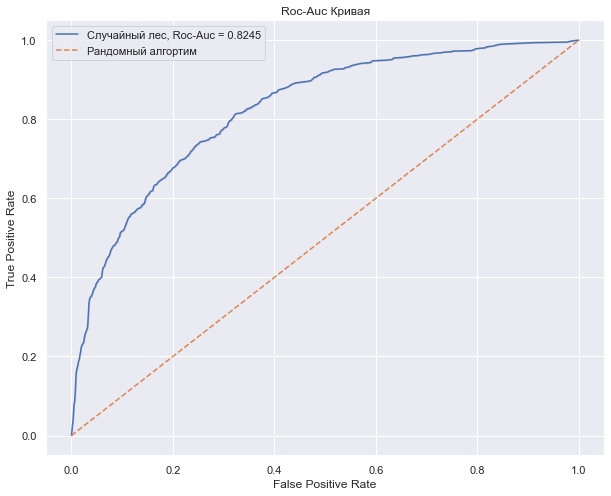

In [90]:
# Построим roc-auc кривую:
sns.set(rc={'figure.figsize':(10,8)})
fallspos, trupos, threshold = roc_curve(y_test, first_pred)
score = round(roc_auc_score(y_test, first_pred),4)
grabgh1 = sns.lineplot(fallspos, trupos, label = f'Случайный лес, Roc-Auc = {score}')
grabgh1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Roc-Auc Кривая')
sns.lineplot([0, 1], [0, 1], label = "Рандомный алгортим", linestyle='--')
None

**Вывод:** Стало только хуже. В таком случае неободимо еще больше обрабатывать имеющиеся данные